In [1]:
import pandas as pd
import numpy as np
import librosa

def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

df = pd.read_csv('Path_DF.csv')
slider_train = df[(df.Dataset == 'train') & (df.Machine_Type == 'slider')]

slider_train.head()

,Path,Machine_Type,Dataset,Status,Machine_ID,Sample_ID,nb_echantillon,freq_echantillonnage,audio
11969,Data/slider/train/normal_id_00_00000692.wav,slider,train,normal,0,692,160000,16000,[-0.01812744 -0.02529907 -0.02410889 ... -0.01...
11970,Data/slider/train/normal_id_06_00000093.wav,slider,train,normal,6,93,160000,16000,[ 0.00030518 -0.01733398 0.00076294 ... -0.01...
11971,Data/slider/train/normal_id_00_00000686.wav,slider,train,normal,0,686,160000,16000,[ 0.00491333 -0.00527954 -0.01107788 ... -0.01...
11972,Data/slider/train/normal_id_06_00000087.wav,slider,train,normal,6,87,160000,16000,[-0.0083313 -0.01031494 -0.01416016 ... 0.00...
11973,Data/slider/train/normal_id_02_00000058.wav,slider,train,normal,2,58,160000,16000,[0.00817871 0.01330566 0.012146 ... 0.005401...


In [56]:
def file_load_stream(wav_name, mono=False):
    frameSize = librosa.get_samplerate(wav_name)
    hoplength = frameSize // 2
    stream = librosa.stream(wav_name, block_length=1, frame_length=frameSize, hop_length=hoplength, mono=mono)
    return stream

In [57]:
file_load_stream(df.iloc[0,0])

<generator object stream at 0x7fb839e22f90>

In [6]:
#help(librosa.stream)

In [8]:
import sys

def file_to_vector_array_stream_test_data(file_name, n_mels=128, frames=5, n_fft=1024, hop_length=512, power=1):
    """
    convert file_name to a vector array.
    file_name : str
        target .wav file
    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames
    
    # 02 generate melspectrogram using librosa
    stream = file_load_stream(file_name)
    sr = librosa.get_samplerate(file_name)
    liste = []
    for n, y in enumerate(stream):
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power)

        # 03 convert melspectrogram

        log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

        # 04 calculate total vector size
        vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1  
        
        # 05 skip too short clips
        if vector_array_size < 1:
            return np.empty((0, dims))

        # 06 generate feature vectors by concatenating multiframes
        vector_array = np.zeros((vector_array_size, dims))

        for t in range(frames):
            vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

        liste.append(vector_array)

    liste2 = np.asarray(liste)
    liste2 = liste2.reshape(liste2.shape[0] * liste2.shape[1], liste2.shape[2])
    return liste2

In [61]:
nb_extract = 532

file_to_vector_array_stream_test_data(df.iloc[0,0]).shape
#file = file.append(list(file_to_vector_array_stream_test_data(df.iloc[1,0])))
#file = np.asarray(file)

(532, 640)

In [13]:
from time import time
t0 = time()

list_slider_train = []
for k in range(len(slider_train)):
    for l in file_to_vector_array_stream_test_data(slider_train.iloc[k,0]):
        list_slider_train.append(l)
slider_train_stream = np.asarray(list_slider_train)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 189.51 secondes


In [14]:
slider_train_stream.shape

(1491728, 640)

In [15]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, BatchNormalization, ReLU, Reshape


In [34]:
model_dense = Sequential()

# Première couche Encoder

model_dense.add(Dense(512, input_shape = (640,)))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Seconde couche Encoder

model_dense.add(Dense(512))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Troisième couche Encoder

model_dense.add(Dense(512))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Quatrième couche Encoder

model_dense.add(Dense(512))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Couche goulot

model_dense.add(Dense(8))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Première couche Decoder

model_dense.add(Dense(512))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Seconde couche Decoder

model_dense.add(Dense(512))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Troisième couche Decoder

model_dense.add(Dense(512))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Quatrième couche Decoder

model_dense.add(Dense(512))
model_dense.add(BatchNormalization())
model_dense.add(ReLU())

# Couche de reconstruction 

model_dense.add(Dense(640))

# On compile 

model_dense.compile(optimizer='adam', loss="mse")


In [17]:
from tensorflow.keras import callbacks

# Callback pour arrêter l'entrainement et récupérer le meilleur modèle si la métrique ne diminue plus pendant 10 epochs
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

import os
cwd = os.getcwd()
filepath = cwd

# Callback pour sauvegarder le meilleur modèle
checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, 
                                       save_weights_only = False, mode = 'min', save_freq = 'epoch')

t0 = time()

# Pour modèle Dense AE
model_dense.fit(slider_train_stream, slider_train_stream, batch_size = 512, epochs = 100, callbacks=[checkpoint, early_stopping], validation_split = 0.3)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Epoch 1/100
2040/2040 [==============================] - 175s 85ms/step - loss: 248.1515 - val_loss: 13.8688
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 2/100
2040/2040 [==============================] - 166s 81ms/step - loss: 12.7042 - val_loss: 13.3859
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 3/100
2040/2040 [==============================] - 140s 68ms/step - loss: 11.5775 - val_loss: 12.4520
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 4/100
2040/2040 [==============================] - 139s 68ms/step - loss: 11.1530 - val_loss: 12.8373
Epoch 5/100
2040/2040 [==============================] - 141s 69ms/step - loss: 10.9242 - val_loss: 12.0073
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 6/100
2040/2040 [==============================] - 146s 71ms/step - loss:

In [98]:
model = tf.saved_model.load('/Users/romeo/Formation DataScientist/projet pynomaly/assets')

OSError: SavedModel file does not exist at: /Users/romeo/Formation DataScientist/projet pynomaly/assets/{saved_model.pbtxt|saved_model.pb}

In [18]:
slider_test = df[(df.Dataset == 'test') & (df.Machine_Type == 'slider')]

t0 = time()

list_slider_test = []
for k in range(len(slider_test)):
    for l in file_to_vector_array_stream_test_data(slider_test.iloc[k,0]):
        list_slider_test.append(l)
slider_test_stream = np.asarray(list_slider_test)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 82.639 secondes


In [19]:
pred_slider_test = model_dense.predict(slider_test_stream)

In [62]:
errors = np.mean(np.square(slider_test_stream - pred_slider_test), axis=1)

error_file = np.zeros(len(slider_test))
for k in range(len(slider_test)):
    error_file[k] = np.mean(errors[k*nb_extract : (k+1)*nb_extract])
    
error_file

array([10.00877228, 15.374784  , 18.02122645, ..., 10.79009596,
       10.90188541,  9.79186526])

In [64]:
y_true = slider_test['Status'].replace(['normal', 'anomaly'], [0,1])

y_true

10679    0
10680    1
10681    1
10682    0
10683    0
        ..
11964    1
11965    1
11966    0
11967    0
11968    0
Name: Status, Length: 1290, dtype: int64

In [68]:
seuil = 12 # valeur à déterminer

y_pred = np.where(error_file[:] > seuil, 1, 0)

pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,337,63
1,150,740


In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, seuils = roc_curve(y_true, error_file, pos_label = 1)

roc_auc = auc(fpr, tpr)



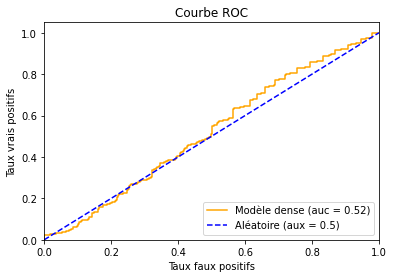

In [28]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)


plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right');

plt.show();

In [45]:
slider_train.Machine_ID.value_counts()

2    968
0    968
6    434
4    434
Name: Machine_ID, dtype: int64

# On recommence avec une seule Machine_ID, on commence avec id = 0

In [32]:
slider_0 = df[(df.Machine_ID == 0) & (df.Machine_Type == 'slider')]
slider_train_0 = slider_0[slider_0['Dataset'] == 'train']
slider_test_0 = slider_0[slider_0['Dataset'] == 'test']


In [33]:
t0 = time()

list_slider_train_0 = []
for k in range(len(slider_train_0)):
    for l in file_to_vector_array_stream_test_data(slider_train_0.iloc[k,0]):
        list_slider_train_0.append(l)
slider_train_0_stream = np.asarray(list_slider_train_0)

list_slider_test_0 = []
for k in range(len(slider_test_0)):
    for l in file_to_vector_array_stream_test_data(slider_test_0.iloc[k,0]):
        list_slider_test_0.append(l)
slider_test_0_stream = np.asarray(list_slider_test_0)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 83.473 secondes


In [35]:
model_dense.fit(slider_train_0_stream, slider_train_0_stream, batch_size = 512, epochs = 100, callbacks=[checkpoint, early_stopping], validation_split = 0.3)

Epoch 1/100
705/705 [==============================] - 59s 80ms/step - loss: 537.8740 - val_loss: 16.2264
Epoch 2/100
705/705 [==============================] - 52s 74ms/step - loss: 13.9296 - val_loss: 13.8276
Epoch 3/100
705/705 [==============================] - 49s 70ms/step - loss: 12.6659 - val_loss: 12.2223
Epoch 4/100
705/705 [==============================] - 52s 74ms/step - loss: 11.9027 - val_loss: 11.9726
Epoch 5/100
705/705 [==============================] - 51s 72ms/step - loss: 11.5125 - val_loss: 13.0076
Epoch 6/100
705/705 [==============================] - 51s 73ms/step - loss: 11.2877 - val_loss: 11.9217
Epoch 7/100
705/705 [==============================] - 54s 77ms/step - loss: 11.0210 - val_loss: 12.9120
Epoch 8/100
705/705 [==============================] - 52s 74ms/step - loss: 10.8375 - val_loss: 11.8179
Epoch 9/100
705/705 [==============================] - 52s 73ms/step - loss: 10.6821 - val_loss: 11.9143
Epoch 10/100
705/705 [==============================] 

In [36]:
pred_slider_test_0 = model_dense.predict(slider_test_0_stream)

In [69]:
errors = np.mean(np.square(slider_test_0_stream - pred_slider_test_0), axis=1)

error_file = np.zeros(len(slider_test_0))
for k in range(len(slider_test_0)):
    error_file[k] = np.mean(errors[k*nb_extract : (k+1)*nb_extract])
    
error_file

array([19.31931867, 23.49917613, 14.38493138, 17.17394456, 15.45670861,
       18.45237837, 16.65653549, 16.31325944, 11.03649895, 13.49018726,
       11.27843476, 10.40334435,  9.72854358, 10.13685927, 10.38706945,
       13.10324089, 19.18666257, 17.1174159 , 22.23435453, 18.08115162,
       22.05358242, 16.63474784, 16.94220655, 15.51759329, 14.77410378,
       17.04671585, 24.16336217, 16.52484383, 21.6655371 , 16.42042262,
       13.5149113 , 15.20903671,  9.79451557, 10.47027735,  9.68264241,
       10.57088434,  9.8570426 , 21.60568361, 18.24955925,  9.81545644,
       10.94094812, 10.60389081, 16.31434881, 22.77152405, 20.50393371,
       18.24951553, 23.7594558 , 14.95280222, 17.74933952, 14.48242325,
       19.19761702, 23.35980972, 15.91786914, 25.54916339, 17.07423006,
       15.89347603, 23.29657122, 22.32816468, 22.90328512, 10.91875074,
       12.18632627, 10.09801508, 10.16044477,  9.99673594, 13.00598908,
       10.55012989,  9.9158505 ,  9.77054245,  9.65621263, 15.46

In [70]:
y_true = slider_test_0['Status'].replace(['normal', 'anomaly'], [0,1])

y_true

10680    1
10681    1
10689    1
10690    1
10692    1
        ..
11956    1
11957    1
11958    1
11964    1
11965    1
Name: Status, Length: 456, dtype: int64

In [90]:
seuil = 12 # valeur à déterminer

y_pred = np.where(error_file[:] > seuil, 1, 0)

pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,80,20
1,2,354


In [91]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       100
           1       0.95      0.99      0.97       356

    accuracy                           0.95       456
   macro avg       0.96      0.90      0.92       456
weighted avg       0.95      0.95      0.95       456



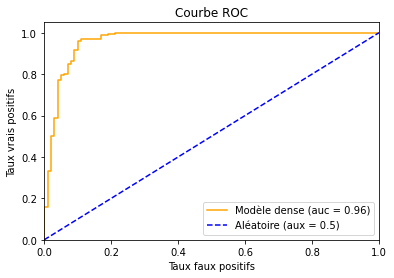

In [80]:
fpr, tpr, seuils = roc_curve(y_true, error_file, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)


plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right');

plt.show();

In [84]:
pred_slider_train_0 = model_dense.predict(slider_train_0_stream)

errors_train = np.mean(np.square(slider_train_0_stream - pred_slider_train_0), axis=1)

error_file_train = np.zeros(len(slider_train_0))
for k in range(len(slider_train_0)):
    error_file_train[k] = np.mean(errors_train[k*nb_extract : (k+1)*nb_extract])
    
error_file_train



array([10.41874518,  9.67987502,  9.84273282, 10.14673073, 10.61813785,
        9.80382818,  9.5702239 , 11.63250501, 11.05223922, 10.09907914,
        9.73098589,  9.5731542 ,  9.85688314, 11.1293661 ,  9.63391668,
        9.59436843,  9.8976356 , 10.05935235,  9.90310222,  9.74289131,
        9.63203317,  9.41626249,  9.57059166,  9.86157955, 10.3506773 ,
        9.70537202,  9.61294249, 10.81393879,  9.9787838 , 10.34003246,
        9.85525039, 10.39638553, 11.79943542, 14.06646473,  9.75218268,
        9.39567932,  9.79735027,  9.87002139,  9.74457331,  9.5773225 ,
        9.54230187,  9.92619977, 10.04392531,  9.74168545, 10.58578757,
        9.55263398, 10.31900818, 10.28901733,  9.93269059,  9.56686236,
       10.69666066,  9.46300597,  9.63829225, 10.04222375,  9.85433937,
        9.86116592, 10.63115002,  9.37560873,  9.65388279,  9.92227575,
        9.88228238,  9.52941716, 10.57799326, 10.0326934 , 10.42993069,
        9.79335315, 10.04489954,  9.83179692,  9.43051291, 10.28

In [88]:
np.mean(error_file_train), np.std(error_file_train)

# Donc un seuil autour de 11.3 est bien pour trouver les prises de sons anormales détectées par le modèle

(10.303473009057187, 0.9947104988861228)